I am using the US Airbnb Datasets. We will be utilizing the dataset to build a model which will attempt to predict prices based on Description using NLP and Sentiment Analysis.

In [1]:
# Data exploration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

In [2]:
df = pd.read_csv('/content/listings.csv')

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,

In [4]:
# Review columns to be used, and drop the rest
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [5]:
# Name represents the description of the listing
df_n = df.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary','space', 'experiences_offered', 
                        'neighborhood_overview','notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url','xl_picture_url', 
                        'host_id', 'host_url', 'host_name', 'host_since','host_location', 'host_about', 'host_response_time',
                        'host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_thumbnail_url', 'host_picture_url', 
                        'host_neighbourhood','host_listings_count', 'host_total_listings_count','host_verifications', 
                        'host_has_profile_pic', 'host_identity_verified','street', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
                        'state', 'zipcode', 'market','smart_location', 'country_code', 'country', 'latitude', 'longitude',
                        'is_location_exact', 'property_type', 'room_type', 'bed_type', 'square_feet', 'weekly_price', 'monthly_price', 
                        'security_deposit','cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights','maximum_nights', 
                        'calendar_updated', 'has_availability','availability_30', 'availability_60', 'availability_90','availability_365', 
                        'calendar_last_scraped', 'number_of_reviews','first_review', 'last_review','review_scores_accuracy', 
                        'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location', 
                        'review_scores_value', 'requires_license','license', 'jurisdiction_names', 'instant_bookable','cancellation_policy', 
                        'require_guest_profile_picture','require_guest_phone_verification', 'calculated_host_listings_count',
                        'reviews_per_month', 'amenities', 'accommodates', 'neighbourhood', 'city', 'review_scores_rating'], inplace=True)

In [6]:
df.head()

,id,description,bathrooms,bedrooms,beds,price
0,241032,Make your self at home in this charming one-be...,1.0,1.0,1.0,$85.00
1,953595,Chemically sensitive? We've removed the irrita...,1.0,1.0,1.0,$150.00
2,3308979,New modern house built in 2013. Spectacular s...,4.5,5.0,7.0,$975.00
3,7421966,A charming apartment that sits atop Queen Anne...,1.0,0.0,2.0,$100.00
4,278830,Cozy family craftman house in beautiful neighb...,2.0,3.0,3.0,$450.00


In [7]:
# Correct datatype for price from str to int
df['price'] = pd.to_numeric(df['price'].map(lambda x: x.strip('$').replace(',','')))
print("price data type: ", type(df['price'].iloc[0]))

price data type:  <class 'numpy.float64'>


Start of NLP

In [8]:
# imports
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re

# define function tokenize

def tokenize(text):
    '''
    for text strings to be tokenized (tokens)
    removing stop words
    Lemmatization
    '''
    tokens = word_tokenize(text)
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df['description'].value_counts(normalize=True)[:10]

Our space is a mix of a hostel and a home. We are a group of long-term residents & subletors who welcome short term guests. This is the house to meet folks whether you are moving to town or traveling through. The house offers quiet and social spaces. Our listing offers a unique Airbnb experience of staying with other Airbnb guests in a shared room as well as in a house of roommates who live in Seattle. This room is a great fit for individual or groups of travelers on a budget who are interested in meeting interesting people right in the place they are staying! We created this house so that people from around the world could meet, share experiences together and potentially create long lasting friendships that go beyond their time in our house. In a big house we are making the world smaller with more connections between people. Below is more information about your shared room, about us and about our house. Read through and see if we are a good fit for your trip! ABOUT YOUR SHARED ROOM:  

In [10]:
# Using the tokenize function
df['description'] = df['description'].apply(str)
df['base_tokens'] = df['description'].apply(tokenize)
df['base_tokens'].head()

0    [make, self, home, charming, onebedroom, apart...
1    [chemically, sensitive, weve, removed, irritan...
2    [new, modern, house, built, 2013, spectacular,...
3    [charming, apartment, sits, atop, queen, anne,...
4    [cozy, family, craftman, house, beautiful, nei...
Name: base_tokens, dtype: object

In [11]:
df[['description', 'base_tokens']][:10]

,description,base_tokens
0,Make your self at home in this charming one-be...,"[make, self, home, charming, onebedroom, apart..."
1,Chemically sensitive? We've removed the irrita...,"[chemically, sensitive, weve, removed, irritan..."
2,New modern house built in 2013. Spectacular s...,"[new, modern, house, built, 2013, spectacular,..."
3,A charming apartment that sits atop Queen Anne...,"[charming, apartment, sits, atop, queen, anne,..."
4,Cozy family craftman house in beautiful neighb...,"[cozy, family, craftman, house, beautiful, nei..."
5,We're renting out a small private unit of one ...,"[renting, small, private, unit, one, seattle, ..."
6,Enjoy a quiet stay in our comfortable 1915 Cra...,"[enjoy, quiet, stay, comfortable, 1915, crafts..."
7,"Our tiny cabin is private , very quiet and com...","[tiny, cabin, private, quiet, comfortable, spo..."
8,"Nestled in the heart of the city, this space i...","[nestled, heart, city, space, turn, century, c..."
9,"Beautiful apartment in an extremely safe, quie...","[beautiful, apartment, extremely, safe, quiet,..."


Analyzing tokens

In [12]:
# Create a function which takes a corpus of document and returns a dataframe of word counts

from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [13]:
wc = count(df['base_tokens'])
print(wc.shape)
wc.head()

(13084, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
25,seattle,2489,4831,1.0,0.013934,0.013934,0.651912
175,room,2049,4427,2.0,0.012769,0.026702,0.536668
58,bedroom,2061,3602,3.0,0.010389,0.037091,0.539811
44,downtown,2094,3092,4.0,0.008918,0.046009,0.548455
68,bed,1940,3046,5.0,0.008785,0.054795,0.508119


Visualizing with Comment Clouds

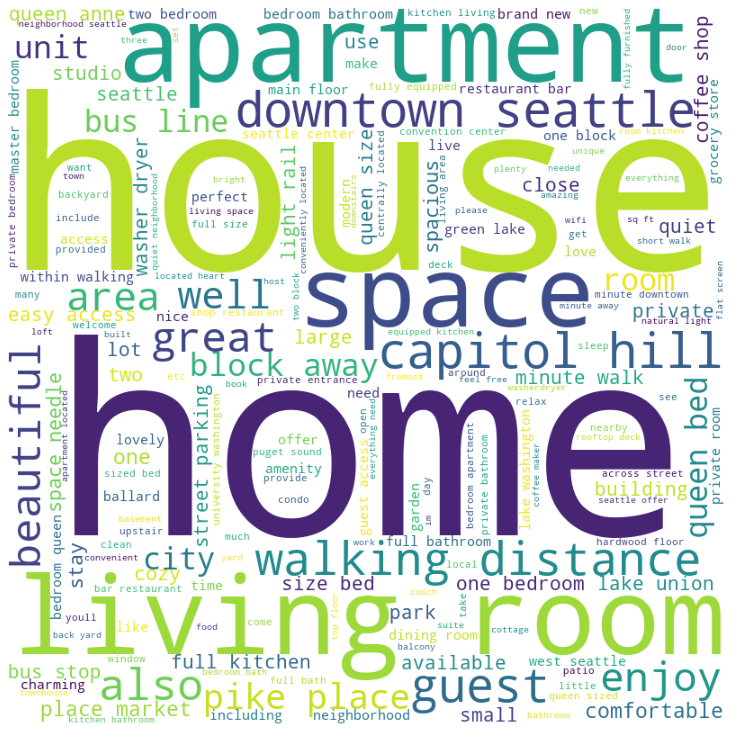

In [14]:
from wordcloud import WordCloud

comment_words = ''
stop_words = set(stopwords.words('english'))

for val in df.base_tokens:
    val = str(val)
    tokens = word_tokenize(val)
    tokens = re.sub('[^a-zA-Z 0-9]', '', val)
    tokens = tokens.lower().split()
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                     background_color='white',
                     stopwords = stop_words,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

Price Prediction Model based on Description

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# initialize pipeline

# Create pipeline components
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
svm = LinearSVC()

# Get sparse dtm
dtm = vect.fit_transform(df.description)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

pipe = Pipeline([
    ('vect', vect),
    ('clf', svm)
])

# split data and remove NA values
df.dropna(inplace=True)
X = df['description']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
           

In [16]:
y_preds = pipe.predict(X_test)
y_preds

array([150., 100.,  42.,  65., 175.,  50., 200.,  62.,  99., 200., 150.,
        70., 275., 150., 300., 100.,  40., 110.,  90., 169.,  65.,  75.,
        95.,  63., 125.,  70.,  85., 125.,  65., 105.,  39., 125.,  85.,
        90.,  80., 150.,  59., 169., 151., 129.,  99.,  39.,  86., 125.,
        70.,  90.,  80., 130.,  85.,  65., 250., 150.,  64., 125., 250.,
       250.,  75., 150., 125.,  90., 125.,  70., 100.,  70., 152., 100.,
        90.,  65.,  50.,  95., 111., 300.,  49.,  41., 200.,  99.,  40.,
        65., 100., 129.,  50.,  85., 175.,  50., 125., 110., 100., 130.,
        85., 125., 150., 129., 149., 110., 100., 150., 109., 115., 275.,
       100.,  70., 125.,  69., 100., 139.,  90.,  80.,  65., 110.,  90.,
       150., 250., 165., 139., 150., 125., 125.,  95.,  99.,  75., 150.,
       110., 100., 110.,  99., 100.,  99., 129.,  55.,  90., 300., 127.,
        99., 129.,  55.,  90., 175., 120., 100.,  75., 125.,  55., 465.,
       125., 110.,  99., 350., 175., 250., 150.,  7

In [17]:
mse = mean_squared_error(y_test, y_preds)
mse

6770.811842105263

In [18]:
from math import sqrt

rmse = sqrt(mse)
rmse

82.284942985368

In [19]:
y_test.head(10)

3176    120.0
3076     58.0
1841    100.0
284      95.0
1860    250.0
1912     75.0
1272    200.0
2684     65.0
217      68.0
2773    100.0
Name: price, dtype: float64

In [20]:
r2 = r2_score(y_test, y_preds)
r2

0.10059053261232331

In [21]:
mae = mean_absolute_error(y_test, y_preds)
mae

48.65921052631579

In [22]:
# GridSearchCV

from sklearn.model_selection import GridSearchCV

target = df['price']

rfc = RandomForestClassifier()

pipe2 = Pipeline([('vect', vect), ('clf', rfc)])


parameters = {
    'vect__max_df': (0.7, 1.0),
    'vect__min_df': (.02, .05, .10),
    'vect__max_features':(500, 1500),
    'clf__n_estimators':(5, 10),
    'clf__max_depth':(5, 10, 15, 20)
}

grid_search = GridSearchCV(pipe2, parameters, cv=5, n_jobs=4, verbose=1)
grid_search.fit(df['description'], target)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:  7.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [23]:
grid_search.best_score_

0.06243152347271341

In [24]:
grid_search.best_params_

{'clf__max_depth': 10,
 'clf__n_estimators': 5,
 'vect__max_df': 1.0,
 'vect__max_features': 500,
 'vect__min_df': 0.02}

In [25]:
from sklearn.metrics import accuracy_score

# Evaluate on test data
y_test = grid_search.predict(df.description)
accuracy_score(target, y_test)

0.16701791359325605

In [26]:
best_model = grid_search.best_estimator_
vect = best_model.named_steps['vect']
clf = best_model.named_steps['clf']

In [27]:
!pip install eli5

     |████████████████████████████████| 112kB 11.5MB/s 


In [28]:
import eli5

eli5.show_weights(clf, vec=vect, top=20)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0165 ± 0.0333,second
0.0164 ± 0.0328,bathrooms
0.0160 ± 0.0401,room
0.0156 ± 0.0290,fully
0.0152 ± 0.0373,shared
0.0148 ± 0.0249,privacy
0.0130 ± 0.0143,west
0.0130 ± 0.0337,quick
0.0129 ± 0.0373,studio
0.0122 ± 0.0302,guests


META LEARNING MODELS

In [29]:
# Create dataframe containing price prediction per description

pred = grid_search.predict(df['description'])

In [30]:
df_pred = pd.DataFrame({'id': df['id'], 'description': df['description'], 'bathrooms': df['bathrooms'], 'bedrooms': df['bedrooms'],
                       'beds': df['beds'], 'price': df['price'], 'pred_price_using_desc': pred})
df_pred.head(30)
# id	description	bathrooms	bedrooms	beds	price

,id,description,bathrooms,bedrooms,beds,price,pred_price_using_desc
0,241032,Make your self at home in this charming one-be...,1.0,1.0,1.0,85.0,100.0
1,953595,Chemically sensitive? We've removed the irrita...,1.0,1.0,1.0,150.0,99.0
2,3308979,New modern house built in 2013. Spectacular s...,4.5,5.0,7.0,975.0,150.0
3,7421966,A charming apartment that sits atop Queen Anne...,1.0,0.0,2.0,100.0,100.0
4,278830,Cozy family craftman house in beautiful neighb...,2.0,3.0,3.0,450.0,150.0
5,5956968,We're renting out a small private unit of one ...,1.0,1.0,1.0,120.0,55.0
6,1909058,Enjoy a quiet stay in our comfortable 1915 Cra...,1.0,1.0,1.0,80.0,100.0
7,856550,"Our tiny cabin is private , very quiet and com...",1.0,1.0,1.0,60.0,55.0
8,4948745,"Nestled in the heart of the city, this space i...",1.0,1.0,1.0,90.0,150.0
9,2493658,"Beautiful apartment in an extremely safe, quie...",1.0,1.0,1.0,150.0,99.0


Sentiment Intensity Analyzer

In [31]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df_pred['polarity_value']="Default"
df_pred['neg']=0.0
df_pred['pos']=0.0
df_pred['neu']=0.0
df_pred['compound']=0.0
for index,row in df_pred.iterrows():
    ss = sid.polarity_scores(row['description'])
    df_pred.at[index,'polarity_value'] = ss
    df_pred.at[index,'neg'] = ss['neg']
    df_pred.at[index,'pos'] = ss['pos']
    df_pred.at[index,'neu']= ss['neu']
    df_pred.at[index,'compound'] = ss['compound']
df_pred.head()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,id,description,bathrooms,bedrooms,beds,price,pred_price_using_desc,polarity_value,neg,pos,neu,compound
0,241032,Make your self at home in this charming one-be...,1.0,1.0,1.0,85.0,100.0,"{'neg': 0.029, 'neu': 0.895, 'pos': 0.076, 'co...",0.029,0.076,0.895,0.8439
1,953595,Chemically sensitive? We've removed the irrita...,1.0,1.0,1.0,150.0,99.0,"{'neg': 0.082, 'neu': 0.606, 'pos': 0.312, 'co...",0.082,0.312,0.606,0.9926
2,3308979,New modern house built in 2013. Spectacular s...,4.5,5.0,7.0,975.0,150.0,"{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp...",0.000,0.123,0.877,0.9665
3,7421966,A charming apartment that sits atop Queen Anne...,1.0,0.0,2.0,100.0,100.0,"{'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compou...",0.000,0.140,0.860,0.6369
4,278830,Cozy family craftman house in beautiful neighb...,2.0,3.0,3.0,450.0,150.0,"{'neg': 0.015, 'neu': 0.856, 'pos': 0.129, 'co...",0.015,0.129,0.856,0.9689


In [33]:
# split data

X = df['description']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [34]:
!pip install category_encoders

     |████████████████████████████████| 81kB 7.6MB/s 


In [35]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on validation
print ('Accruacy', pipeline.score(X_test, y_test))

# Predict on test
y_pred = pipeline.predict(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Accruacy 0.05263157894736842


In [36]:
# Save Model File

import pickle

filename = 'finalized_model.sav'
pickle.dump(pipeline, open(filename, 'wb'))